# Titanic

## 项目介绍
这是Taggle上的第一篇教程性质的项目，  1912年的泰坦尼克沉船事件导致1502名游客的死亡，而船上共有2224名游客。现在，我们掌握了船上乘客的一些数据和乘客是否获救的信息，通过对数据进行分析以及机器学习方法，最后我们要做到的是对任意一个从未出现在给定数据的乘客，预测他是否获救  
- 通过该项目，对数据处理，特征工程，以及机器学习应用等方面产生一个较为清晰的认识。  
- 同时，由于是教学性质的文章，我会对一些代码写尽可能详细的注释，便于理解和学习。

## 目录

1. 数据分析
2. 特征工程
3. baseline

## 包导入
我们会使用总共三大类的python lib，1.数据处理； 2.可视化； 3.机器学习

In [338]:
#数据处理
import os
import pandas as pd
import numpy as np
import random
import sklearn.preprocessing as preprocessing

#可视化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (GradientBoostingClassifier, GradientBoostingRegressor, 
                              RandomForestClassifier, RandomForestRegressor)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import warnings
warnings.filterwarnings('ignore')


# 1. 数据分析
首先，将给定数据导入到程序中，然后后对每个属性，进行简要的分析和可视化，从而探索出属性和label之间的关系，为之后的特征工程做准备。  
先看一下数据的大概状况

In [339]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


对于每个乘客，共有11个特征，以及对应的每个乘客是否获救的label.  
乘客信息如下
- PassengerId = 乘客ID
- Pclass = 乘客等级（1/2/3等仓）
- Name,Sex, Age
- SibSp = 兄弟姐妹个数
- Parch = 父母和小孩个数
- Ticket = 船票信息
- Fare = 船票价格
- Cabin = 客仓
- Embarked = 登船港口  

接下来，对每个特征看一下类型信息

In [340]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


通过以上信息，我们发现在给定数据中，Age，Cabin， Embarked存在**数据缺失**，尤其Cabin缺失很严重    
我们继续对所有的数值数据进行探索：

In [341]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


观察下各个特征之间的协方差

Text(0.5,1,'train feature corr')

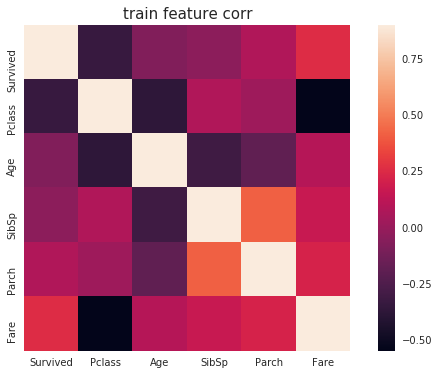

In [342]:
sns.set(context="paper", font="monospace")
sns.set(style="white")
f, ax = plt.subplots(figsize=(10,6))
train_corr = train.drop('PassengerId',axis=1).corr()
sns.heatmap(train_corr, ax=ax, vmax=.9, square=True)
ax.set_title('train feature corr', fontsize=15)

通过协方差，我们可以得出以下结论：
- Pclass乘客等级和获救**负相关**
- Fare价格和获救**正相关**，给的钱多的优先
- Pclass和Fare负相关，正常，一等仓最贵

## 1.1 年龄分析：
对乘客的年龄特征进行分析，首先画出年龄分布曲线，对于缺失值，使用age=-20进行填补

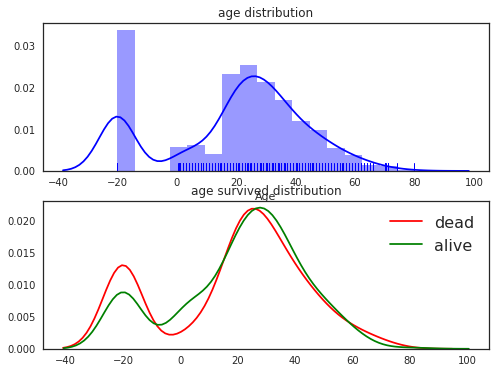

In [343]:
from scipy import stats
fig, axes = plt.subplots(2,1,figsize=(8,6))
ax0 = axes[0]
ax0.set_title('age distribution')
ax0.set_xlabel('')
sns.distplot(train.Age.fillna(-20), rug=True, color='b', ax=ax0)


ax1 = axes[1]
ax1.set_title('age survived distribution')
k1 = sns.distplot(train[train.Survived==0].Age.fillna(-20), hist=False, color='r', ax=ax1, label='dead')
k2 = sns.distplot(train[train.Survived==1].Age.fillna(-20), hist=False, color='g', ax=ax1, label='alive')
ax1.set_xlabel('')
ax1.legend(fontsize=16)


通过对年龄分布进行分析，可以得到以下信息：
1. 可以看出，小孩和20多岁的青年以及中年获救可能性较大
2. 获救情况和年龄**不成现线性关系，所以如果使用线性模型需要对年龄进行离散处理，作为类型变量带入模型**
3. 获救的人中，年龄缺少的人比例要小于有年龄信息的人（获救之后对乘客信息重新登记导致？）

## 1.2 Pclass 仓位分析
仓位可能是影响是否获救的一个重要属性。   
首先，绘制出仓位和获救情况的简要分析柱状图：

Text(0.5,1,'Pclass Surveved count')

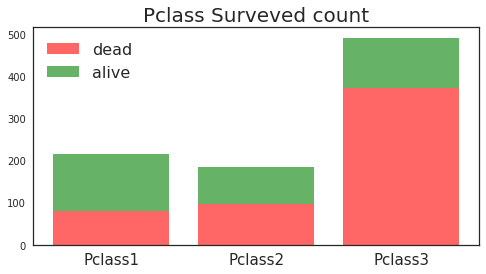

In [344]:
y_dead = train[train.Survived==0].groupby('Pclass')['Survived'].count()
y_alive = train[train.Survived==1].groupby('Pclass')['Survived'].count()
pos = [1, 2, 3]
ax = plt.figure(figsize=(8,4)).add_subplot(111)
ax.bar(pos, y_dead, color='r', alpha=0.6, label='dead')
ax.bar(pos, y_alive, color='g', bottom=y_dead, alpha=0.6, label='alive')
ax.legend(fontsize=16, loc='best')
ax.set_xticks(pos)
ax.set_xticklabels(['Pclass%d'%(i) for i in range(1,4)], size=15)
ax.set_title('Pclass Surveved count', size=20)

- 头等舱（Pclass=1），商务舱（Pclass=2），经济舱（Pclass=3）
- 经济舱人数遥遥领先
- 比较来说，**头等舱获救比例最大，经济舱死亡概率最大**

## 1.3 性别分析
我们知道，在泰坦尼克这样的危机事件中，通常遵循着女士优先的原则，所以我们需要对性别这个属性简要的分析。  
首先，统计出男性和女性分别的获救情况。

In [345]:
print(train.Sex.value_counts())
print('===================================')
print(train.groupby('Sex')['Survived'].mean())

male      577
female    314
Name: Sex, dtype: int64
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


Text(0.5,1,'Sex Survived count')

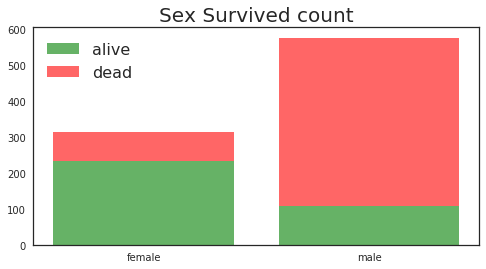

In [346]:
sex_alive = train[train.Survived == 1].groupby('Sex')['Survived'].count()
sex_dead = train[train.Survived == 0].groupby('Sex')['Survived'].count()
ax = plt.figure(figsize=(8,4)).add_subplot(111)
pos = [1, 2]
ax.bar(pos, sex_alive, color='g',alpha=0.6,label='alive')
ax.bar(pos, sex_dead, color='r', bottom=sex_alive,alpha=0.6,label='dead')

ax.legend(fontsize=16, loc='best')
ax.set_xticks(pos)
ax.set_xticklabels(['female','male'], size=10)
ax.set_title('Sex Survived count', size=20)

可以看出：
- 全部乘客中，男性人数大于女性，接近1.5倍
- 获救乘客中，大部分为女性，是男性的4倍，女性生存率远大于男性

##### 性别和年龄和生存情况

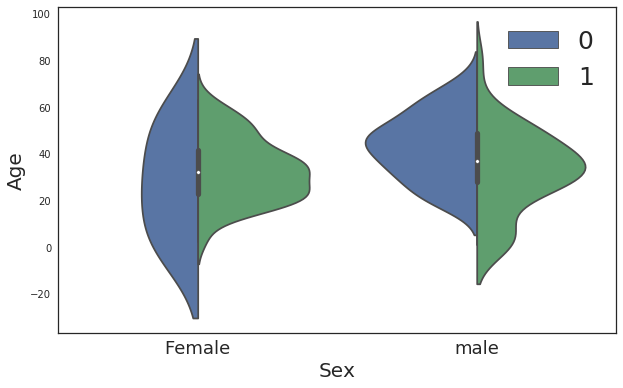

In [347]:
ax = plt.figure(figsize=(10, 6)).add_subplot(111)
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train.dropna(),split=True)
ax.set_xlabel('Sex', size=20)
ax.set_xticklabels(['Female', 'male'], size=18)
ax.set_ylabel('Age', size=20)
ax.legend(fontsize=25, loc='best')

从分布可以看出：
- 女性获救年龄主要分布在20岁左右的青年
- 青年男性获救概率要大于中年男性，年轻人和小孩更容易获救

##### 性别仓位和获救情况分布

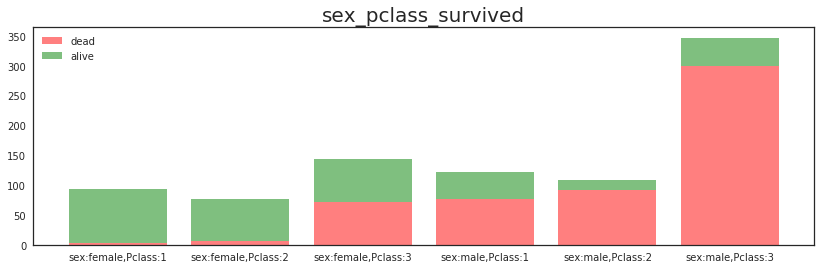

In [348]:
label = []
for sex_i in ['female','male']:
    for pclass_i in range(1,4):
        label.append('sex:%s,Pclass:%d'%(sex_i, pclass_i))
        
pos = range(6)
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)
ax.bar(pos, 
        train[train['Survived']==0].groupby(['Sex','Pclass'])['Survived'].count().values, 
        color='r', 
        alpha=0.5, 
        align='center',
        tick_label=label, 
        label='dead')
ax.bar(pos, 
        train[train['Survived']==1].groupby(['Sex','Pclass'])['Survived'].count().values, 
        bottom=train[train['Survived']==0].groupby(['Sex','Pclass'])['Survived'].count().values,
        color='g',
        alpha=0.5,
        align='center',
        tick_label=label, 
        label='alive')
ax.tick_params(labelsize=10)
ax.set_title('sex_pclass_survived', size=20)
ax.legend(fontsize=10,loc='best')

可以发现，头等舱的女性几乎都获救了，由此观之，我们或许 **可以构造一个“头等舱&女性”的特征，该特征为1时，几乎一定会获救**

## 1.4 票价(Fare)
票价在一定程度上可以反应乘客的经济地位，该属性对是否获救有一定意义   
首先，看一下票价的分布

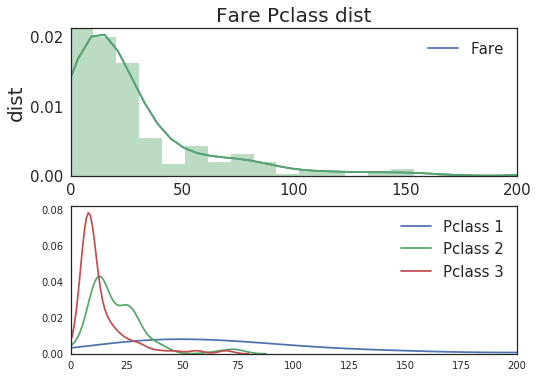

In [349]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot2grid((2,2), (0,0), colspan=2)

ax.tick_params(labelsize=15)
ax.set_title('Fare dist', size=20)
ax.set_ylabel('dist', size=20)
sns.kdeplot(train.Fare, ax=ax)
sns.distplot(train.Fare, ax=ax)
ax.legend(fontsize=15)
pos = range(0,400,50)
ax.set_xticks(pos)
ax.set_xlim([0, 200])
ax.set_xlabel('')

ax1 = plt.subplot2grid((2,2), (1,0), colspan=2)
ax.set_title('Fare Pclass dist', size=20)
for i in range(1,4):
    sns.kdeplot(train[train.Pclass==i].Fare, ax=ax1, label='Pclass %d'%(i))
ax1.set_xlim([0,200])
ax1.legend(fontsize=15)

##### 票价和获救情况的关系

Text(0.5,0,'Fare')

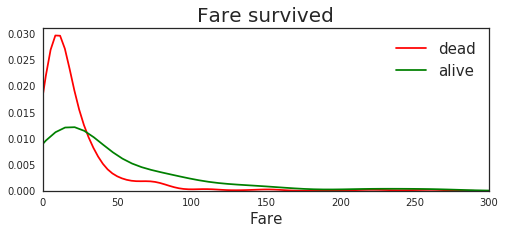

In [350]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(111)
sns.kdeplot(train[train.Survived==0].Fare, ax=ax1, label='dead', color='r')
sns.kdeplot(train[train.Survived==1].Fare, ax=ax1, label='alive', color='g')
#sns.distplot(train[train.Survived==0].Fare, ax=ax1, color='r')
#sns.distplot(train[train.Survived==1].Fare, ax=ax1, color='g')
ax1.set_xlim([0,300])
ax1.legend(fontsize=15)
ax1.set_title('Fare survived', size=20)
ax1.set_xlabel('Fare', size=15)

可以发现，当票价等于30左右时，死亡率等于获救率，所以考虑可以将票价 **离散化切割成三段，0～30，30～50，50～150以及150+** ，将其作为一个离散特征处理。

## 1.5 sibsp&parch 表亲和直亲
直观上来看，该属性和是否获救没有较大的关系，但还是可以对其进行探索。

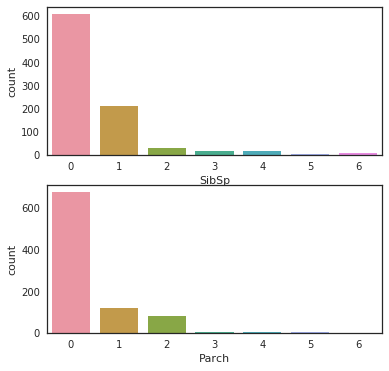

In [351]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(211)
sns.countplot(train.SibSp)
ax2 = fig.add_subplot(212, sharex=ax1)
sns.countplot(train.Parch)

可以发现，绝大多数乘客并没有表亲和直亲  

然后对表亲&直亲和获救情况的分布进行探索

Text(0.5,1,'Parch+Sibsp Survived Rate')

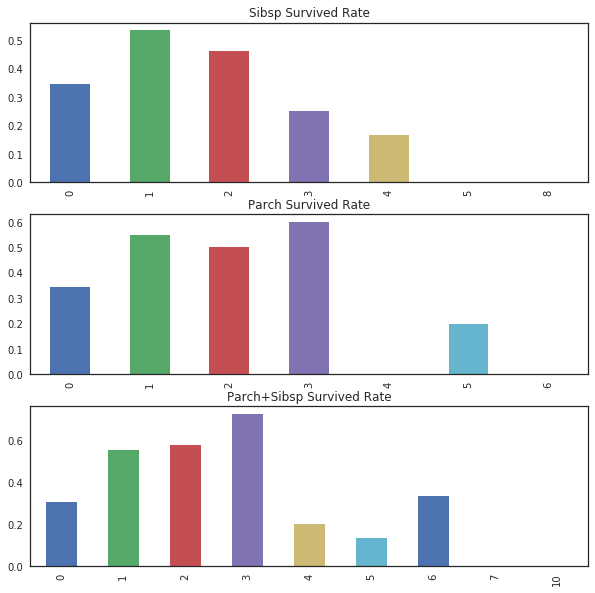

In [352]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
train.groupby('SibSp')['Survived'].mean().plot(kind='bar', ax=ax1)
ax1.set_title('Sibsp Survived Rate', size=12)
ax1.set_xlabel('')

ax2 = fig.add_subplot(312)
train.groupby('Parch')['Survived'].mean().plot(kind='bar', ax=ax2)
ax2.set_title('Parch Survived Rate', size=12)
ax2.set_xlabel('')

ax3 = fig.add_subplot(313)
train.groupby(train.SibSp+train.Parch)['Survived'].mean().plot(kind='bar', ax=ax3)
ax3.set_title('Parch+Sibsp Survived Rate', size=12)

分组统计不同人数亲戚的获救率来看，都近似呈现先高后低, 亲人数目多少和是否获救不是简单的线性关系，但可以发现，表亲&直亲=1，2，3的乘客获救可能性较高，同时也说明该属性和获救情况有一定关联， **可以作为特征保留**。

## 1.6 Embarked 上船地点
上船地点因为可以在一定侧面反应船舱位置，经济情况等信息，所以需要进行一定的分析，进而决定是否保留该属性作为特征。

Text(0.5,1,'Embarked survived count')

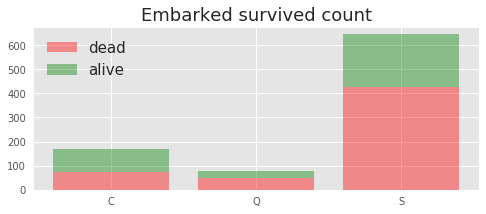

In [353]:
plt.style.use('ggplot')
ax = plt.figure(figsize=(8,3)).add_subplot(111)
pos = [1, 2, 3]
y1 = train[train.Survived==0].groupby('Embarked')['Survived'].count().sort_index().values
y2 = train[train.Survived==1].groupby('Embarked')['Survived'].count().sort_index().values
ax.bar(pos, y1, color='r', alpha=0.4, align='center', label='dead')
ax.bar(pos, y2, color='g', alpha=0.4, align='center', label='alive', bottom=y1)
ax.set_xticks(pos)
ax.set_xticklabels(['C','Q','S'])
ax.legend(fontsize=15, loc='best')
ax.set_title('Embarked survived count', size=18)

可以看出，从c港上船的乘客更容易获救 **//进一步使用统计数据探索每个登船口的获救比率（为nan的数据也需要显示）**

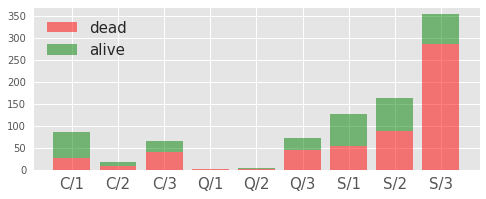

In [354]:
y1 = train[train.Survived==0].groupby(['Embarked','Pclass'])['Survived'].count().reset_index()['Survived'].values
y2 = train[train.Survived==1].groupby(['Embarked','Pclass'])['Survived'].count().reset_index()['Survived'].values

ax = plt.figure(figsize=(8,3)).add_subplot(111)
pos = range(9)
ax.bar(pos, y1, align='center', alpha=0.5, color='r', label='dead')
ax.bar(pos, y2, align='center', bottom=y1, alpha=0.5, color='g', label='alive')

ax.set_xticks(pos)
xticklabels = []
for embarked_val in ['C','Q','S']:
    for pclass_val in range(1,4):
        xticklabels.append('%s/%d'%(embarked_val,pclass_val))

ax.set_xticklabels(xticklabels,size=15)
ax.legend(fontsize=15, loc='best')

从不同仓位的比例来看，似乎C上岸更容易获救是因为头等舱的人较多？

C/1的获救比例要高于60%，远远高出其他分布， **似乎可以单独提取出来作为一个特征。**

## 1.7 Cabin 船舱号

对属性船舱号进行分析   
首先看一下缺失情况

In [355]:
train.Cabin.isnull().value_counts()

True     687
False    204
Name: Cabin, dtype: int64

In [356]:
train.groupby(by=train.Cabin.isnull())['Survived'].mean()

Cabin
False    0.666667
True     0.299854
Name: Survived, dtype: float64

- Cabin大部分为空，所以初步分析该属性不适合缺失值填充
- 为空的获救概率较低，不为空的获救概率较高。**说明该数据可以作为特征**

通过观察发现，Cabin被用字母分为不同区域，对每个区域的生存状况做一个简要的分析。

In [357]:
train['Cabin_Zone'] = train.Cabin.fillna('N').str.split(' ').apply(lambda x: x[0][0])
train.groupby(by='Cabin_Zone')['Survived'].agg(['mean', 'count'])

,mean,count
Cabin_Zone,,
A,0.466667,15
B,0.744681,47
C,0.593220,59
D,0.757576,33
E,0.750000,32
F,0.615385,13
G,0.500000,4
N,0.299854,687
T,0.000000,1


In [358]:
test['Cabin_Zone'] = test.Cabin.fillna('N').str.split(' ').apply(lambda x:x[0][0])

把每个Cabin中的区域提取出来之后，统计发现不同区域获救概率差别很大，**或许可以作为一个特征**，但Cabin缺失值过多，能否作为一个特征需要重新判断。

#### 1.2.8 姓名特征
最开始认为Name这个特征没有任何意义，但我们发现，所给数据中的姓名信息不仅仅是姓名，而且包括称谓，甚至包括性别，地位，财富，婚姻状况等都可能包含在姓名中。所以，对于Name不能直接将其当作垃圾特征处理。  
首先，对姓名的长度和获救状况进行探索：














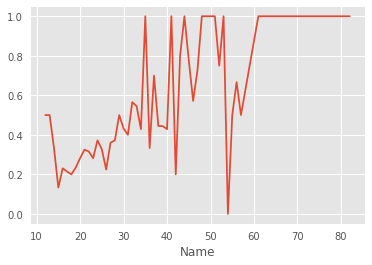

In [359]:
train.groupby(train.Name.apply(lambda x:len(x)))['Survived'].mean().plot()

可以发现，似乎名字越长，获救可能性越高，所以 **名字长度** 可以作为一个特征

同时通过观察发现，乘客的名字不简简单单只有名字，更有对乘客的称谓，不同的称谓应该也和获救情况有关联：

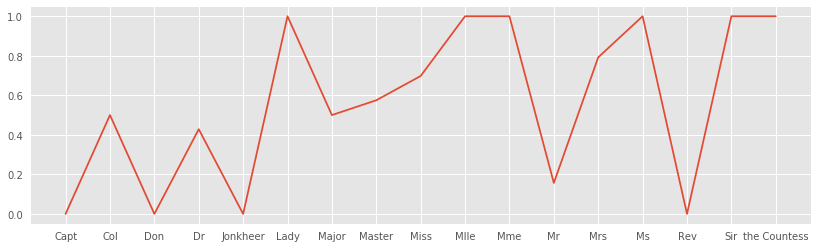

In [360]:
name_title = train.groupby(train['Name'].apply(
    lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0]))['Survived'].mean()
ax = plt.figure(figsize=(14,4)).add_subplot(111)
ax.plot(name_title)

In [361]:
name_title = train['Name'].apply(
    lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
name_title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
the Countess      1
Lady              1
Capt              1
Sir               1
Mme               1
Jonkheer          1
Don               1
Ms                1
Name: Name, dtype: int64

In [362]:
name_title = test['Name'].apply(
    lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
name_title.value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dr          1
Ms          1
Dona        1
Name: Name, dtype: int64

于是我们把称谓信息提取出来，由于有些称谓的人数量过少，不适合作为一个单独的分类，所以我们还需要做一个映射将数量过少的称谓映射到相同的称谓集合中，遵循的思想是：**获救程度相同的称谓映射到同一个集合中:**
- (Capt, Don, Jonkheer, Rev, Mr) --> titleA
- (Col, Dr, Major, Master, Miss) --> titleB
- (Lady, Mlle, Mme, Mrs, Ms, Sir, the Countess, Dona) --> titleC  

人名title科普：
Mme：非英语民族"上层社会"已婚妇女相当于Mrs Mlle:小姐 Lady：贵族夫人   
Jonkheer:乡绅  Capt：船长  sir：先生 the Countess：女伯爵  
Don唐：西班牙语贵族的尊称 Rev：牧师 Ms.或Mz：婚姻状态不明的妇女    
Major：少校 Lieutenant(Lt)：中尉  Colonel(Col)：上校   
测试集合中特殊的Dona：女士尊称  

# 2. 特征工程
针对数据分析环节中得出的结论，进行特征工程。  
首先查看所有数据中为null的数据：


In [363]:
print('============train===========')
print(train.isnull().sum())

============train===========
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Cabin_Zone       0
dtype: int64


In [364]:
print('============test============')
print(test.isnull().sum())

============test============
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Cabin_Zone       0
dtype: int64


1. age 和 cabin在训练集和测试集都有缺失，cabin缺失数量巨大
2. embarked 在训练集存在2个缺失
3. fare在测试集有一个缺失

## 2.1 embarked 处理
首先，对embarked进行处理，查看embarked的缺失情况。  
因为只有2个数据存在缺失，所以不适合将“缺失”重新定义一个分类，我们想办法对其进行填补：

In [365]:
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Zone
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B


我们发现两个embark缺失的乘客Pclass=1，cabin_zone=B   
所以我们先查看一下Pclass=1和Cabin_Zone=B的乘客中Embarked的情况。

In [366]:
print(train.Embarked.value_counts())
print('=========================')
print(train[train.Pclass==1].Embarked.value_counts())
print('=========================')
print(train[train.Cabin_Zone=='B'].Embarked.value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
S    127
C     85
Q      2
Name: Embarked, dtype: int64
S    23
C    22
Name: Embarked, dtype: int64


- 不分Pclass仓位来看的话，S embarked人数远大于C，Q
- Pclass==1的乘客中，S embarked的人数也是最多。  
- 在Cabin_Zone为B的乘客中，S emarked的人数也是最多的。

**所以，因为缺失数据很少，可以考虑随最大可能数据填补缺失值，因此设定缺失值为S**

In [367]:
train.Embarked.fillna('S', inplace=True)

## 2.2 cabin处理

在之前的数据探索环节，我们知道cabin为空的获救概率较低，不为空的获救概率较高。说明该数据可以作为特征。所以我们对cabin作填充处理

In [368]:
#若为NaN,则用字符串‘Null’填充，否则用'Not Null'填充
train['Cabin'] = train['Cabin'].isnull().apply(lambda x: 'Null' if x is True else 'Not Null')
test['Cabin'] = test['Cabin'].isnull().apply(lambda x: 'Null' if x is True else 'Not Null')
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Zone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Null,S,N
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,Not Null,C,C


## 2.3 Name和Ticket处理
在数据分析中，我们知道名字的长度和是否获救有一定的正相关性，所以，将名字的长度加入到表中作为一个feature。

In [369]:
train['Name_Len'] = train['Name'].apply(lambda x:len(x))
test['Name_Len'] = test['Name'].apply(lambda x:len(x))
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Zone,Name_Len
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Null,S,N,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,Not Null,C,C,51
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Null,S,N,22


按照数据分析中对人名中title的整合方式，构造title feature：

- (Capt, Don, Jonkheer, Rev, Mr) --> titleA
- (Col, Dr, Major, Master, Miss) --> titleB
- (Lady, Mlle, Mme, Mrs, Ms, Sir, the Countess, Dona) --> titleC 

In [370]:
train['Title'] = train['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
train['Title'] = train['Title'].replace(['Don', 'Capt', 'Jonkheer', 'Rev','Mr'],'titleA')
train['Title'] = train['Title'].replace(['Col', 'Dr', 'Major', 'Master', 'Miss'], 'titleB')
train['Title'] = train['Title'].replace(['Lady', 'Mlle', 'Mme', 'Mrs','Ms', 'Sir', 'the Countess','Dona'], 'titleC')

test['Title'] = test['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
test['Title'] = test['Title'].replace(['Don', 'Capt', 'Jonkheer', 'Rev','Mr'],'titleA')
test['Title'] = test['Title'].replace(['Col', 'Dr', 'Major', 'Master', 'Miss'], 'titleB')
test['Title'] = test['Title'].replace(['Lady', 'Mlle', 'Mme', 'Mrs', 'Ms', 'Sir', 'the Countess','Dona'], 'titleC')

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Zone,Name_Len,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Null,S,N,23,titleA
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,Not Null,C,C,51,titleC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Null,S,N,22,titleB


将title和name—length单独提取为特征后，原属性Name失去意义，直接删除；  
同时，对于Ticket属性，分析认为该属性没有意义，同样直接删除；

In [371]:
del train['Name'], test['Name']
del train['Ticket'], test['Ticket']
train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin_Zone,Name_Len,Title
0,1,0,3,male,22.0,1,0,7.2500,Null,S,N,23,titleA
1,2,1,1,female,38.0,1,0,71.2833,Not Null,C,C,51,titleC
2,3,1,3,female,26.0,0,0,7.9250,Null,S,N,22,titleB


## 2.4 年龄离散化处理
在我们对数据进行观察时，发现获救情况和年龄不是存在简单的线性关系，有较多信息可以提取：
- 对年龄进行离散化处理   
- 考虑到年龄缺失的数量较多，同时年龄缺失的乘客获救可能性小于非缺失的乘客，所以将缺失设为一个特征：Age_Null   
- 创建特征：IsChild，对于年龄小于18岁的乘客置为1（数据分析环节发现age<18的获救可能性较大）
- 创建特征：IsOld，对于年龄大于60岁的乘客置为1（数据分析环节中发现age>60的获救可能性较大）

In [372]:
train['Age_Null'] = train.Age.isnull().apply(lambda x:'null' if x is True else 'not_null')
train['Is_Child'] = np.where(train['Age']<=18, 1, 0)
train['Is_Old'] = np.where(train['Age']>=60, 1, 0)
group = train.groupby(['Title', 'Pclass','Sex'])['Age']
train['Age'] = group.transform(lambda x: x.fillna(x.median()))
train['Age'] = pd.cut(train['Age'], 10)

test['Age_Null'] = test.Age.isnull().apply(lambda x:'null' if x is True else 'not_null')
test['Is_Child'] = np.where(test['Age']<=18, 1, 0)
test['Is_Old'] = np.where(test['Age']>=60, 1, 0)
group = test.groupby(['Title', 'Pclass','Sex'])['Age']
test['Age'] = group.transform(lambda x: x.fillna(x.median()))
test['Age'] = pd.cut(test['Age'], 10)

train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin_Zone,Name_Len,Title,Age_Null,Is_Child,Is_Old
0,1,0,3,male,"(16.336, 24.294]",1,0,7.2500,Null,S,N,23,titleA,not_null,0,0
1,2,1,1,female,"(32.252, 40.21]",1,0,71.2833,Not Null,C,C,51,titleC,not_null,0,0
2,3,1,3,female,"(24.294, 32.252]",0,0,7.9250,Null,S,N,22,titleB,not_null,0,0


## 2.5 fare属性
在test集中存在一个数据的fare为缺失值，对于这个变量，可以用平均值进行填补

In [373]:
test[test.Fare.isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin_Zone,Name_Len,Title,Age_Null,Is_Child,Is_Old
152,1044,3,male,"(53.251, 60.834]",0,0,NaN,Null,S,N,18,titleA,not_null,0,1


In [374]:
test.loc[test.Fare.isnull(), 'Fare'] = \
test[(test.Pclass==3) & (test.Embarked=='S') & (test.Sex=='male')].dropna().Fare.mean()
test[test.Fare.isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin_Zone,Name_Len,Title,Age_Null,Is_Child,Is_Old


## 2.6 所有特征转化成数值型编码

In [375]:
features = train.drop(["PassengerId","Survived"], axis=1).columns
le = LabelEncoder()
for feature in features:
    le = le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    
features = test.drop(["PassengerId"], axis=1).columns
for feature in features:
    le = le.fit(test[feature])
    test[feature] = le.transform(test[feature])
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin_Zone,Name_Len,Title,Age_Null,Is_Child,Is_Old
0,1,0,2,1,2,1,0,18,1,2,7,11,0,0,0,0
1,2,1,0,0,4,1,0,207,0,0,2,39,2,0,0,0
2,3,1,2,0,3,0,0,41,1,2,7,10,1,0,0,0
3,4,1,0,0,4,1,0,189,0,2,2,32,2,0,0,0
4,5,0,2,1,4,0,0,43,1,2,7,12,0,0,0,0


## 2.7 归一化处理
为防止数值型特征分布较为广泛导致模型收敛过慢以及仅仅因为数值型大小导致对结果影响的权重有较大影响，  
对数据中所有数值型特征进行归一化处理：“Fare”，“Name_Len”

In [336]:
scaler = preprocessing.StandardScaler()
fare_scale_param = scaler.fit(train['Fare'].values.reshape(-1, 1))
train.Fare = fare_scale_param.transform(train['Fare'].values.reshape(-1, 1))
test.Fare = fare_scale_param.transform(test['Fare'].values.reshape(-1, 1))

nameLen_scale_param = scaler.fit(train['Name_Len'].values.reshape(-1, 1))
train.Name_Len = nameLen_scale_param.transform(train['Name_Len'].values.reshape(-1, 1))
test.Name_Len = nameLen_scale_param.transform(test['Name_Len'].values.reshape(-1, 1))

train.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin_Zone,Name_Len,Title,Age_Null,Is_Child,Is_Old
0,0,2,1,2,1,0,-1.247170,1,2,7,-0.431498,0,0,0,0
1,1,0,0,4,1,0,1.451165,0,0,2,2.647740,2,0,0,0
2,1,2,0,3,0,0,-0.918801,1,2,7,-0.541471,1,0,0,0


### 2.8 得到训练/测试数据集

In [381]:
X_data = train.drop(["PassengerId","Survived"],axis=1)
y_data = train.Survived

X_test = test.drop(["PassengerId"], axis=1)


# X_all = train.iloc[:891,:].drop(['PassengerId', 'Survived'], axis=1)
# Y_all = train.iloc[:891,:]['Survived']
# X_test = train.iloc[891:,:].drop(['PassengerId', 'Survived'], axis=1)

# 3 模型训练和调优
对比10个常用的模型并估计每个模型平均准确率。

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Neural network
- kNN
- Logistic Regression
- Linear Discriminant Analysis

In [45]:
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

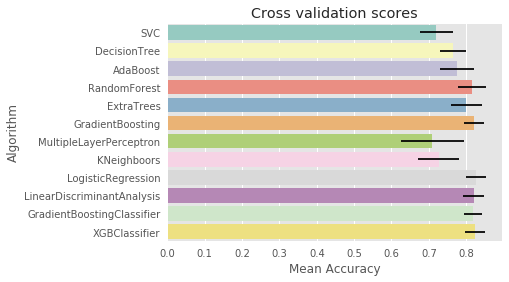

In [382]:
# cross validate model with kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

#modeling step test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3))
classifiers.append(XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05))
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_data, y=y_data, scoring='accuracy', cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression",
                "LinearDiscriminantAnalysis","GradientBoostingClassifier","XGBClassifier"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

通过观察，发现对于该任务有些模型表现较差，有些表现优异，所以挑选表现优异的几个模型，并把他们组合在一起，可能有更好的效果。经考虑，决定对以下几个模型进行集成：
1. AdaBoost
1. RandomForest
2. ExtraTrees
2. Gradientoosting
3. LogisiticRegression
4. LinearDiscriminantAnalysis
5. GradientBoosting
6. XGBT

## 模型集成
首先定义集成框架：

In [42]:
class Ensemble(object):
    
    def __init__(self,estimators):
        self.estimator_names = []
        self.estimators = []
        for i in estimators:
            self.estimator_names.append(i[0])
            self.estimators.append(i[1])
        self.clf = LogisticRegression()
    
    def fit(self, train_x, train_y):
        for i in self.estimators:
            i.fit(train_x,train_y)
        x = np.array([i.predict(train_x) for i in self.estimators]).T
        y = train_y
        self.clf.fit(x, y)
    
    def predict(self,x):
        x = np.array([i.predict(x) for i in self.estimators]).T
        #print(x)
        return self.clf.predict(x)
    
    def score(self,x,y):
        s = precision_score(y,self.predict(x))
        return s

将基分类器放入集成框架中。

In [398]:
rf = RandomForestClassifier(random_state=random_state)
gbc = GradientBoostingClassifier(random_state=random_state)
lr = LogisticRegression(random_state = random_state)
lda = LinearDiscriminantAnalysis()
gdc = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
xgbt = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
ada = AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)
etree = ExtraTreesClassifier(random_state=random_state)

bag = Ensemble([
    ('rf',rf),('gbc',gbc),('lr',lr),('lda',lda),('gdc',gdc),('xgbt',xgbt),('etree',etree),('ada', ada)])
score = 0
for i in range(0,10):
    num_test = 0.20
    X_train, X_cv, Y_train, Y_cv = train_test_split(X_data, y_data, test_size=num_test)
    bag.fit(X_train, Y_train)
    #Y_test = bag.predict(X_test)
   # print(bag.predict(X_test))
    acc_xgb = round(bag.score(X_cv, Y_cv) * 100, 2)
    score+=acc_xgb

print(score/10)  #79

76.135


In [392]:
gender_submission = pd.DataFrame({'PassengerId':test["PassengerId"],'Survived':bag.predict(X_test)})
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


将最后预测结果保存，用以提交到Kaggle

In [393]:
#gender_submission.to_csv('gender_submission_2.csv',index=None)

In [44]:
# def plot_learning_curve(clf, title, X, y, ylim=None, cv=None, n_jobs=3, train_sizes=np.linspace(.05, 1., 5)):
#     train_sizes, train_scores, test_scores = learning_curve(
#         clf, x, y, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
    
#     ax = plt.figure().add_subplot(111)
#     ax.set_title(title)
#     if ylim is not None:
#         ax.ylim(*ylim)
#     ax.set_xlabel(u"train_num_of_samples")
#     ax.set_ylabel(u"score")

#     ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
#                      alpha=0.1, color="b")
#     ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
#                      alpha=0.1, color="r")
#     ax.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"train score")
#     ax.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"testCV score")

#     ax.legend(loc="best")

#     midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
#     diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
#     return midpoint, diff

# plot_learning_curve(grd, u"learning_rate", train_x, train_y)

# gender_submission = pd.DataFrame({'PassengerId':test.iloc[:,0],'Survived':grd.predict(test_x)})
# gender_submission.to_csv('C:/Users/evilpsycho/Desktop/gender_submission.csv', index=None)

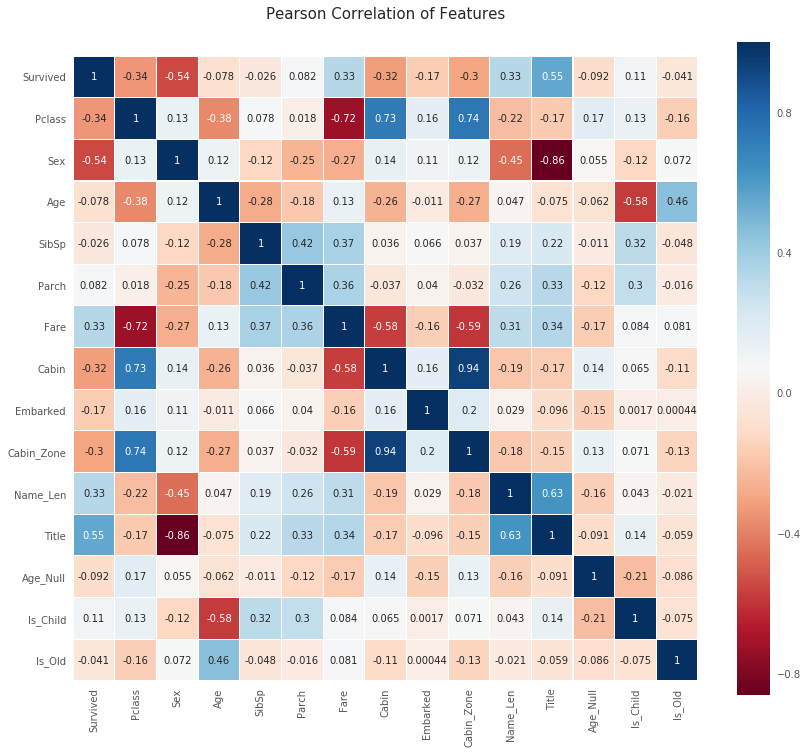

In [400]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.drop(['PassengerId'],axis=1).astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)